# Building our First Model

In [1]:
!python --version

Python 3.10.12


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.3/802.3 kB 71.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyl

In [4]:
import torch
import torchvision
from torchvision import datasets, transforms
import torchmetrics
import lightning as L
import numpy as np
import matplotlib.pyplot as plt
import os
import collections
import pandas as pd
import seaborn as sns
import time
import copy

Load in our train dataset's mean and standard deviation values we calculated previously.

In [5]:
mean = np.array([0.6760, 0.6308, 0.5746])
std = np.array([0.2055, 0.2108, 0.2250])

In [6]:
!pwd

/content


In [7]:
!ls drive/MyDrive/garbage

random_plastic.jpeg  TEST  TRAIN  VGG16_2epochs_model.pth


In [8]:
data_dir = 'drive/MyDrive/garbage'
sets = ['TRAIN', 'TEST']

Define transformations. We may need to adjust the image size from Resize.

In [9]:
data_transforms = {
    'TRAIN':transforms.Compose([
        transforms.Resize(size=(150, 300)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]),
    'TEST':transforms.Compose([
        transforms.Resize(size=(150, 300)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
}

In [ ]:
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform=data_transforms[x])
#                   for x in sets}

In [10]:
dataset = datasets.ImageFolder(os.path.join(data_dir, sets[0]), transform=data_transforms['TRAIN'])
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1], generator=generator)

In [11]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

32837
4104
4104


#Let's find out the distribution of our classes in the training dataset.

In [12]:
train_set_targets = torch.tensor([train_dataset.dataset.targets[i] for i in train_dataset.indices])
train_set_targets.shape

torch.Size([32837])

In [13]:
from collections import Counter
train_targets_list = train_set_targets.tolist()
class_counts = Counter(train_targets_list)
class_counts_dict = dict(class_counts)
class_counts_dict

{1: 2271,
 5: 4288,
 0: 1181,
 2: 13753,
 10: 1555,
 8: 990,
 3: 1388,
 7: 1953,
 9: 3143,
 4: 1556,
 6: 759}

In [14]:
class_idx_dict = dataset.class_to_idx
class_idx_dict

{'PET': 0,
 'books_and_paper': 1,
 'burnable': 2,
 'cans': 3,
 'cardboard': 4,
 'clothes': 5,
 'danger': 6,
 'glass_bin': 7,
 'metal': 8,
 'nonburn': 9,
 'plastic': 10}

In [15]:
for i, key in enumerate(class_idx_dict.keys(), start=0):
    class_idx_dict[key] = class_counts_dict[i]
class_idx_dict

{'PET': 1181,
 'books_and_paper': 2271,
 'burnable': 13753,
 'cans': 1388,
 'cardboard': 1556,
 'clothes': 4288,
 'danger': 759,
 'glass_bin': 1953,
 'metal': 990,
 'nonburn': 3143,
 'plastic': 1555}

Text(0.5, 1.0, 'Train Dataset Class Distribution')

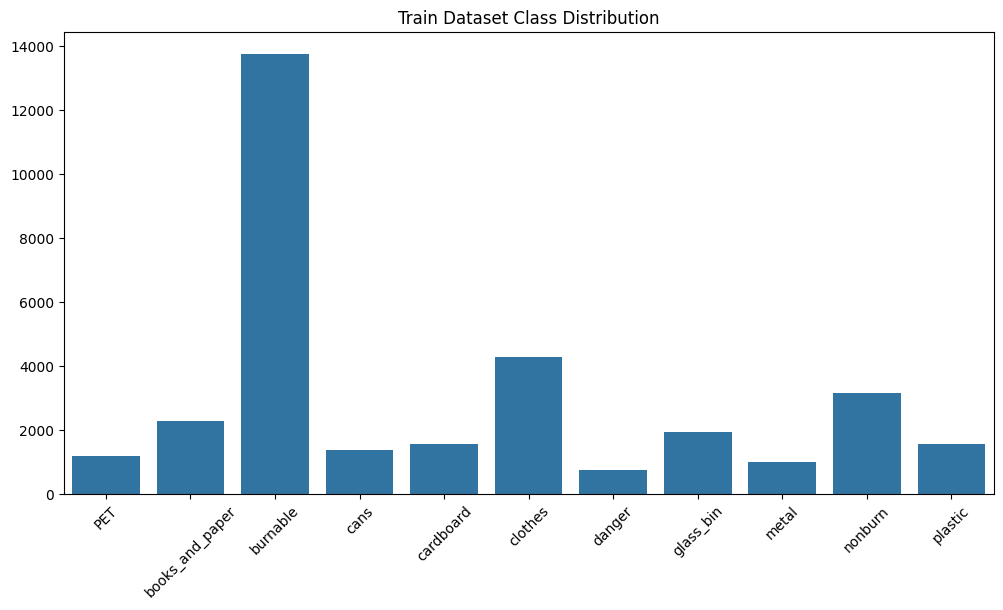

In [16]:
plt.figure(figsize=(12,6))
sns.barplot(class_idx_dict)
plt.xticks(rotation=45)
plt.title('Train Dataset Class Distribution')

In [17]:
for key, value in class_idx_dict.items():
    print(f'Training Dataset is {round(value/len(train_dataset)*100,2)}% {key}')

Training Dataset is 3.6% PET
Training Dataset is 6.92% books_and_paper
Training Dataset is 41.88% burnable
Training Dataset is 4.23% cans
Training Dataset is 4.74% cardboard
Training Dataset is 13.06% clothes
Training Dataset is 2.31% danger
Training Dataset is 5.95% glass_bin
Training Dataset is 3.01% metal
Training Dataset is 9.57% nonburn
Training Dataset is 4.74% plastic


Increasing the batch size may make training faster, but could also lead to increased model bias.

In [18]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True, batch_size=32, num_workers=11)
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset, shuffle=False, batch_size=32, num_workers=11)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, shuffle=False, batch_size=32, num_workers=11)

In [19]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

torch.Size([32, 3, 150, 300])
tensor([ 2,  7,  8,  6, 10,  5,  2,  5,  4,  5,  9,  9, 10,  1,  6,  2,  2,  2,
         2,  6,  2,  5,  8,  2,  5, 10, 10,  2,  3,  5,  2,  3])


Text(0.5, 1.0, 'Training Batch Image Sample')

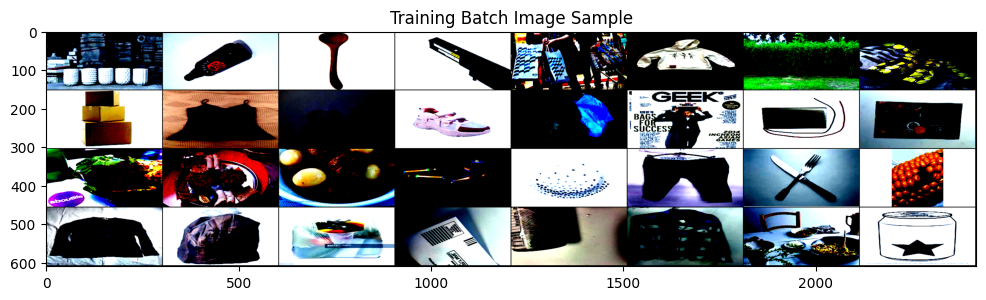

In [20]:
images, labels = next(iter(train_dataloader))
print(images.shape)
print(labels)
plt.figure(figsize=(12,6))
imshow(torchvision.utils.make_grid(images))
plt.title('Training Batch Image Sample')

Define our model.

In [21]:
base_model = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)
# check number of features input to final linear layer of model
num_features = base_model.classifier[6].in_features
num_features

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 199MB/s]


4096

In [22]:
base_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [23]:
class GarbageModel(L.LightningModule):
    def __init__(self, num_channels, num_classes):
        super().__init__()
        base_model = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)
        # check number of features input to final linear layer of model
        num_features = base_model.classifier[6].in_features
        base_model.classifier[6] = torch.nn.Linear(in_features=num_features, out_features=num_classes)
        for param in base_model.features.parameters(): # freeze all the model parameters in the features part
          param.requires_grad = False
        self.model = base_model
        self.num_classes = num_classes
        self.loss_function = torch.nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes=num_classes)
        self.precision = torchmetrics.classification.MulticlassPrecision(num_classes=num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

    def _commmon_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.loss_function(logits, y)
        return loss, logits, y

    def training_step(self, batch, batch_idx):
      loss, logits, y = self._commmon_step(batch, batch_idx)
      accuracy = self.accuracy(logits, y)
      precision = self.precision(logits, y)
      self.log_dict({'training_loss':loss, 'training_accuracy': accuracy, 'training_precision': precision})
      return loss

    def validation_step(self, batch, batch_idx):
      loss, logits, y = self._commmon_step(batch, batch_idx)
      accuracy = self.accuracy(logits, y)
      precision = self.precision(logits, y)
      self.log_dict({'validation_loss':loss, 'validation_accuracy': accuracy, 'validation_precision': precision})
      return loss

    def test_step(self, batch, batch_idx):
      loss, logits, y = self._commmon_step(batch, batch_idx)
      accuracy = self.accuracy(logits, y)
      precision = self.precision(logits, y)
      self.log_dict({'test_loss':loss, 'test_accuracy': accuracy, 'test_precision': precision})
      return loss

    def predict_step(self, batch, batch_idx):
      x, y = batch
      logits = self.forward(x)
      preds = torch.argmax(logits, dim=1)
      return preds

    def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
      scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.8)
      return [optimizer], [scheduler]

In [24]:
model = GarbageModel(num_channels=3, num_classes=11)

In [25]:
model

GarbageModel(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (

In [26]:
torch.cuda.is_available()
torch.cuda.device_count()

1

In [27]:
csv_logger = L.pytorch.loggers.CSVLogger('drive/MyDrive/garbage/logs')

In [29]:
trainer = L.Trainer(accelerator='auto', max_epochs=10, logger=csv_logger)
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:lightning.pytorch.utilities.rank_zero:You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


# Save the model checkpoint so it can be loaded again

In [32]:
checkpoint_path = 'drive/MyDrive/garbage/VGG16_10epochs_model.pth'
trainer.save_checkpoint(checkpoint_path)

# Load in model and evaluate on test dataset

In [33]:
model = GarbageModel.load_from_checkpoint(checkpoint_path, num_channels=3, num_classes=11)

In [34]:
results = trainer.test(model, dataloaders=test_dataloader)
results

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.24025122821331024    │
│         test_loss         │     1.460386872291565     │
│      test_precision       │    0.2190026491880417     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.460386872291565,
  'test_accuracy': 0.24025122821331024,
  'test_precision': 0.2190026491880417}]

In [54]:
import pandas as pd
import seaborn as sns

In [36]:
csv_file_path = 'drive/MyDrive/garbage/logs/lightning_logs/version_0/metrics.csv'
metrics_df = pd.read_csv(csv_file_path)
metrics_df.head()

epoch  step  test_accuracy  test_loss  test_precision  training_accuracy  \
0      0    49            NaN        NaN             NaN           0.475000   
1      0    99            NaN        NaN             NaN           0.503968   
2      0   149            NaN        NaN             NaN           0.251748   
3      0   199            NaN        NaN             NaN           0.319444   
4      0   249            NaN        NaN             NaN           0.421429   

   training_loss  training_precision  validation_accuracy  validation_loss  \
0      30.067581            0.366250                  NaN              NaN   
1      35.986908            0.510684                  NaN              NaN   
2      46.170219            0.219008                  NaN              NaN   
3     128.713120            0.356111                  NaN              NaN   
4     119.419434            0.415909                  NaN              NaN   

   validation_precision  
0                   NaN  
1                   NaN  
2                   NaN  
3                   NaN  
4                   NaN

In [57]:
train_metrics = metrics_df[~metrics_df['training_loss'].isna()][['epoch', 'step','training_loss', 'training_accuracy', 'training_precision']]
val_metrics = metrics_df[~metrics_df['validation_loss'].isna()][['epoch','validation_loss', 'validation_accuracy', 'validation_precision']]
test_metrics = metrics_df[~metrics_df['test_loss'].isna()][['test_loss', 'test_accuracy', 'test_precision']]
train_metrics.head()

epoch  step  training_loss  training_accuracy  training_precision
0      0    49      30.067581           0.475000            0.366250
1      0    99      35.986908           0.503968            0.510684
2      0   149      46.170219           0.251748            0.219008
3      0   199     128.713120           0.319444            0.356111
4      0   249     119.419434           0.421429            0.415909

Text(0.5, 1.0, 'Training and Validation Loss')

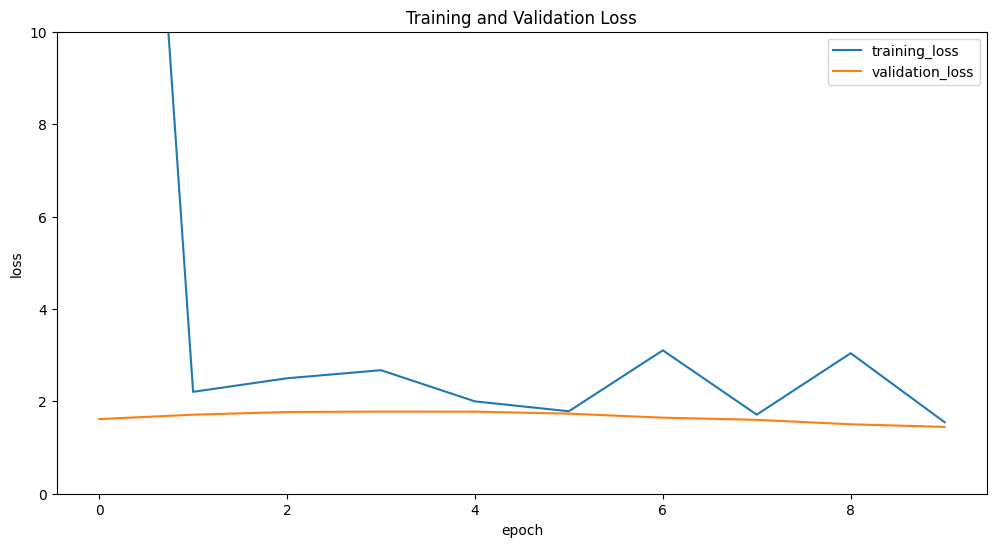

In [63]:
plt.figure(figsize=(12,6))
sns.lineplot(data=train_metrics, x='epoch', y='training_loss', label='training_loss', errorbar=None)
sns.lineplot(data=val_metrics, x='epoch',y='validation_loss', label='validation_loss')
plt.legend()
plt.ylim(0, 10)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Training and Validation Loss')

Text(0.5, 1.0, 'Training and Validation Accuracy')

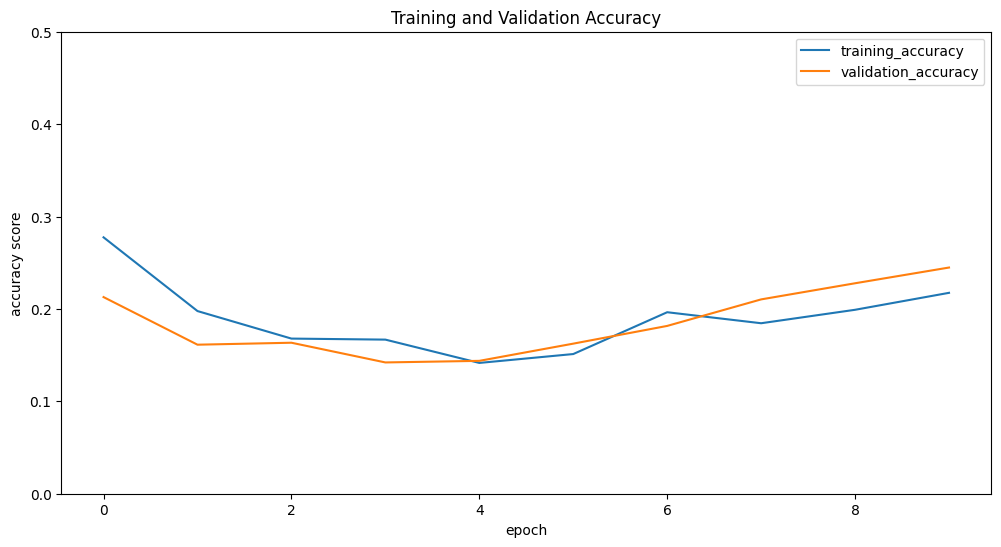

In [62]:
plt.figure(figsize=(12,6))
sns.lineplot(data=train_metrics, x='epoch', y='training_accuracy', label='training_accuracy', errorbar=None)
sns.lineplot(data=val_metrics, x='epoch',y='validation_accuracy', label='validation_accuracy')
plt.legend()
plt.ylim(0, 0.5)
plt.ylabel('accuracy score')
plt.xlabel('epoch')
plt.title('Training and Validation Accuracy')

In [ ]:
!pwd

/content


In [61]:
from PIL import Image

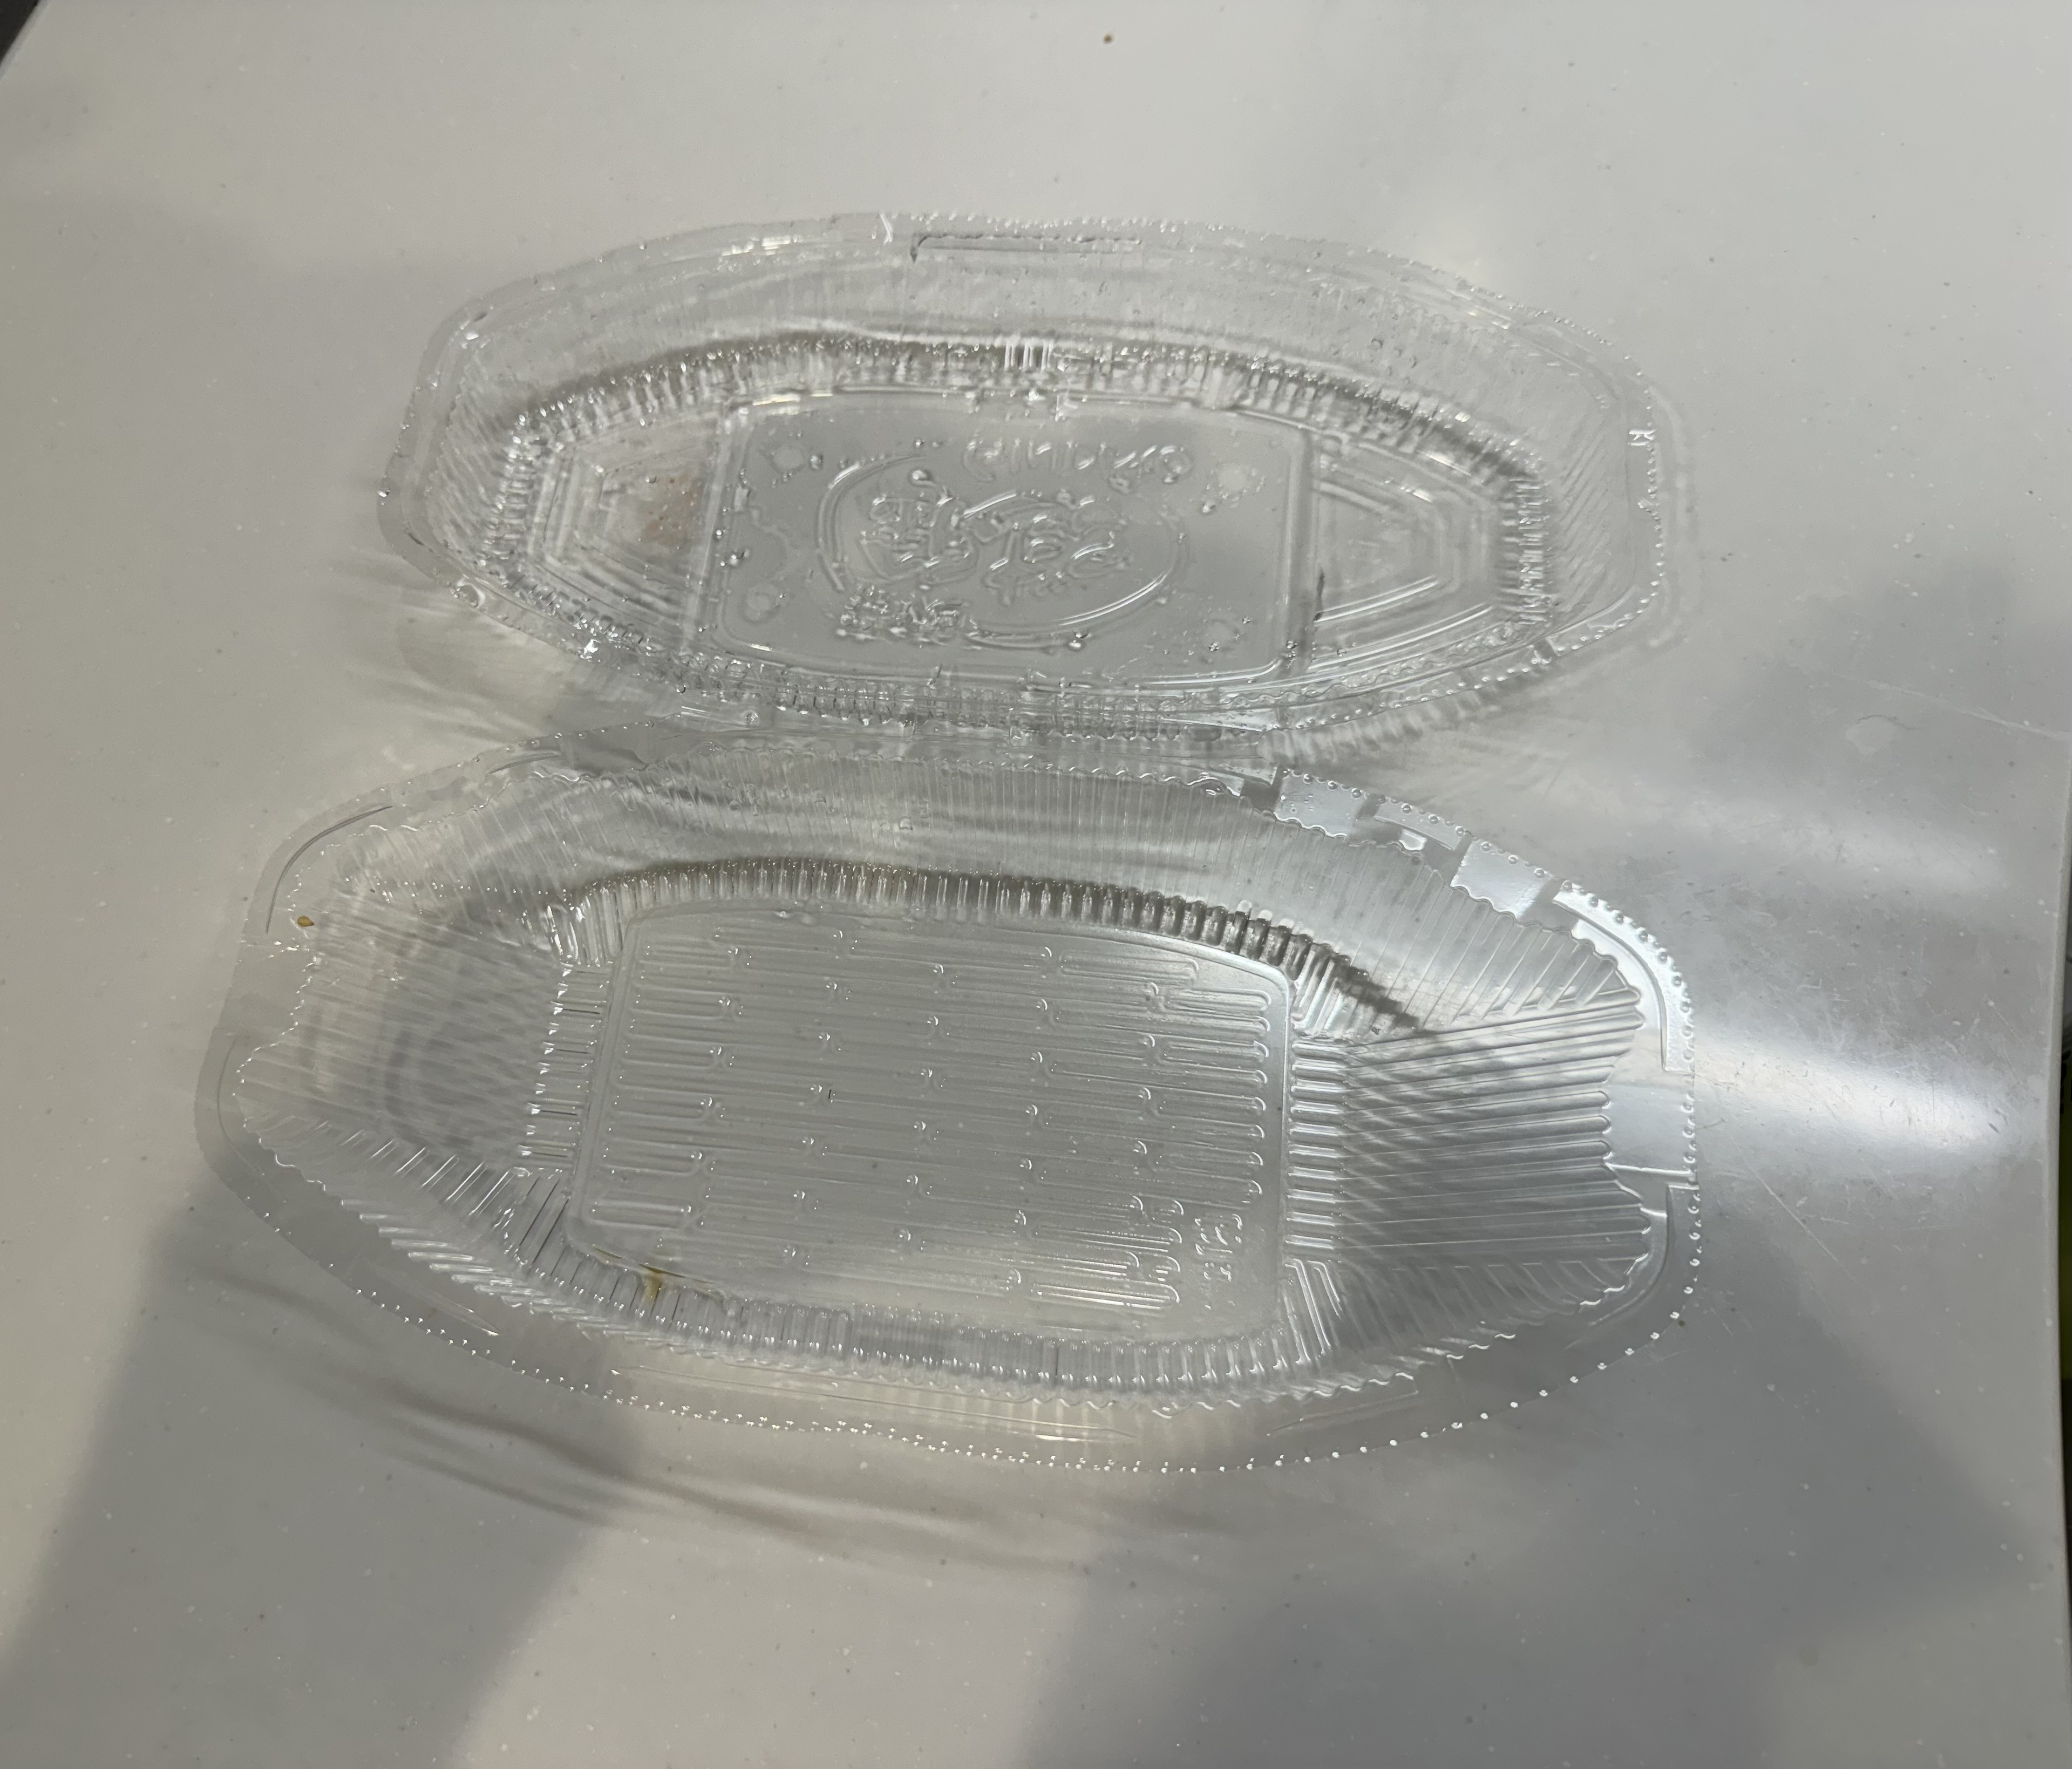

In [64]:
my_tester = Image.open(os.path.join(os.getcwd(), 'drive/MyDrive/garbage/random_plastic.jpeg')).convert('RGB')
my_tester

In [65]:
my_tester = data_transforms['TEST'](my_tester)
my_tester.unsqueeze_(0)
my_tester.shape

torch.Size([1, 3, 150, 300])

In [66]:
type(my_tester)

torch.Tensor

In [67]:
with torch.no_grad():
  pred = model(my_tester)
  _, predicted_class = torch.max(pred, 1)
  print(predicted_class)

tensor([2])


In [68]:
classes_mapping_dict = {0: 'PET',
 1: 'books_and_paper',
 2: 'burnable',
 3: 'cans',
 4: 'cardboard',
 5:'clothes',
 6:'danger',
 7:'glass_bin',
 8:'metal',
 9:'nonburn',
 10:'plastic'}

In [69]:
print(f'Model prediction: {classes_mapping_dict[predicted_class.item()]}')

Model prediction: burnable
